In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

pd.set_option("display.max_rows", None)

In [2]:
options = pd.read_csv(r"data\cleaned_options_data.csv")

# Step 1: Convert the 'ts_recv' column to datetime (this is already optimized)
options["datetime"] = pd.to_datetime(options["ts_recv"], format="%Y-%m-%dT%H:%M:%S.%fZ")

# Step 2: Vectorized parsing of the 'symbol' column
# Split by spaces and extract the relevant parts directly
symbol_parts = options["symbol"].str.split(" ", expand=True)[
    3
]  # Get the fourth part (index 3)

# Extract expiration date (first 6 characters)
options["exp_date"] = pd.to_datetime(symbol_parts.str[:6], format="%y%m%d")

# Extract action ('C' or 'P', at index 6)
options["action"] = symbol_parts.str[6]

# Extract strike price (from index 7 onward, divided by 1000)
options["strike_price"] = symbol_parts.str[7:].astype(float) / 1000

# Step 3: Rename the other columns as needed
options = options.rename(
    columns={
        "bid_px_00": "bidp",
        "ask_px_00": "askp",
        "bid_sz_00": "bid_sz",
        "ask_sz_00": "ask_sz",
    }
)
options["datetime"] = (
    pd.to_datetime(options["datetime"])
    .dt.tz_localize("UTC")
    .dt.tz_convert("US/Eastern")
    .dt.tz_localize(None)
)
options["date"] = options["datetime"].dt.date

In [3]:
underlying = pd.read_csv(r"data\spx_minute_level_data_jan_mar_2024.csv")
underlying = underlying.loc[underlying["price"] > 0]
underlying["date"] = pd.to_datetime(underlying["date"], format="%Y%m%d")

underlying = (
    underlying.groupby("date")
    .agg(
        Open=("price", "first"),
        High=("price", "max"),
        Low=("price", "min"),
        Close=("price", "last"),
    )
    .reset_index()
)

In [4]:
indices = underlying["date"].searchsorted(options["datetime"])
indices = indices.clip(0, len(underlying) - 1)
options["underlying"] = underlying["Close"].iloc[indices].values

In [5]:
options["deviate"] = abs(options["underlying"] - options["strike_price"])

In [6]:
min_exp_date_per_group = options.groupby(["date", "action"])["exp_date"].transform(
    "min"
)
result = options[options["exp_date"] == min_exp_date_per_group]
indices = result.groupby(["date", "action", "exp_date"])["deviate"].idxmin()
result = result.loc[indices].reset_index(drop=True)

In [7]:
indices = underlying["date"].searchsorted(result["exp_date"])
indices = indices.clip(0, len(underlying) - 1)
exp_underlyings = underlying["Close"].iloc[indices].values

Make sure to check for:

- Expiration date is before end of interval
- Both call and put exist and have same expiration date
- Deviations from the underlying is below some threshold


In [8]:
profits = []
for i in range(0, len(result), 2):
    ccall = result.iloc[i]  # First row (Call)
    cput = result.iloc[i + 1]  # Second row (Put)

    # Calculate values based on the given formula
    exp_price = exp_underlyings[i]
    underlying_cost = ccall["askp"] + cput["askp"]
    call_profit = 100 * (exp_price - ccall["strike_price"])
    put_profit = 100 * (cput["strike_price"] - exp_price)
    overall_profit = max(call_profit, 0) + max(put_profit, 0) - underlying_cost

    # Store the calculated profit
    profits.append((ccall["datetime"], overall_profit))

In [9]:
result.columns

Index(['ts_recv', 'instrument_id', 'bidp', 'askp', 'bid_sz', 'ask_sz',
       'symbol', 'datetime', 'exp_date', 'action', 'strike_price', 'date',
       'underlying', 'deviate'],
      dtype='object')

In [18]:
orders = pd.DataFrame(columns=["datetime", "option_symbol", "action", "order_size"])
for i in range(0, len(result), 2):
    ccall = result.iloc[i]  # First row (Call)
    cput = result.iloc[i + 1]  # Second row (Put)

    # IF SOME CONDITION
    if ccall["exp_date"] >= datetime(2024, 3, 31):
        continue
    order_size = min(ccall["ask_sz"], cput["ask_sz"])
    new_rows = pd.DataFrame(
        [
            {
                "datetime": ccall["ts_recv"],  # ts_recv for the Call option
                "option_symbol": ccall["symbol"],  # Use the Call option symbol
                "action": "B",  # Action for the Call option
                "order_size": order_size,  # Minimum ask size
            },
            {
                "datetime": cput["ts_recv"],  # ts_recv for the Call option
                "option_symbol": cput["symbol"],  # Use the Call option symbol
                "action": "B",  # Action for the Call option
                "order_size": order_size,  # Minimum ask size
            },
        ]
    )
    orders = pd.concat(
        [orders, new_rows],
        ignore_index=True,
    )

# Backtesting Code


In [19]:
from datetime import datetime
from backtester import Backtester
from feed_strategy import Strategy

start = datetime(2024, 1, 1)
end = datetime(2024, 3, 30)
s = Strategy(orders)
b = Backtester(start, end, s)

In [20]:
b.calculate_pnl()

2024-01-01 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-02 00:00:00 capital: 99990058.0 portfolio value: 9000.0 total pnl: 99999058.0 open orders: 2
2024-01-03 00:00:00 capital: 99975559.0 portfolio value: 22560.0 total pnl: 99998119.0 open orders: 4
2024-01-04 00:00:00 capital: 99963939.2 portfolio value: 33239.8 total pnl: 99997179.0 open orders: 6
2024-01-05 00:00:00 capital: 99958791.2 portfolio value: 37433.8 total pnl: 99996225.0 open orders: 8
2024-01-06 00:00:00 capital: 99958791.2 portfolio value: 37433.8 total pnl: 99996225.0 open orders: 8
2024-01-07 00:00:00 capital: 99958791.2 portfolio value: 37433.8 total pnl: 99996225.0 open orders: 8
2024-01-08 00:00:00 capital: 99944069.2 portfolio value: 51203.8 total pnl: 99995273.0 open orders: 10
2024-01-09 00:00:00 capital: 99928579.2 portfolio value: 65735.8 total pnl: 99994315.0 open orders: 12
2024-01-10 00:00:00 capital: 99909532.7 portfolio value: 83825.3 total pnl: 99993358.0 op

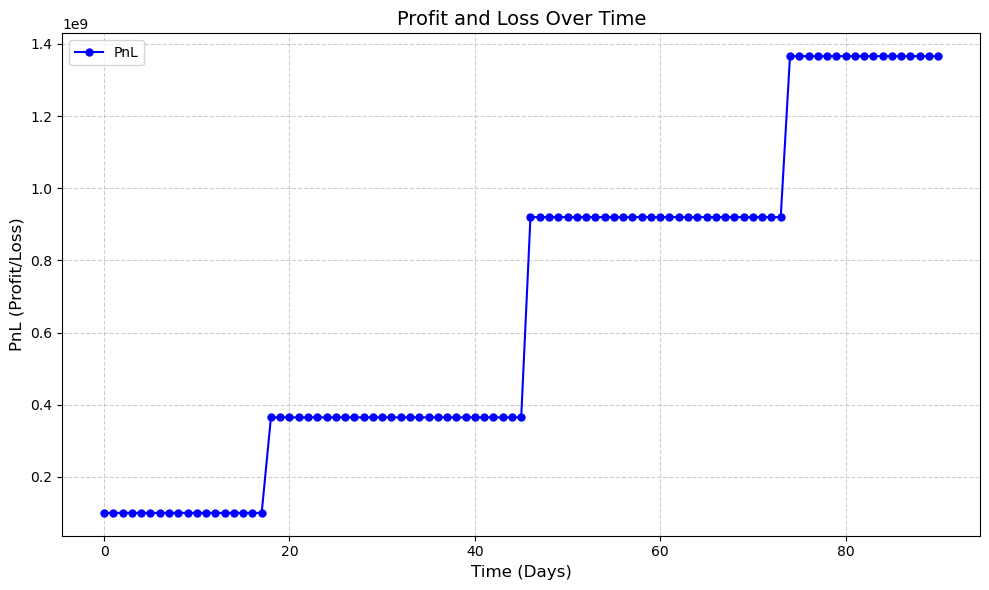

In [21]:
b.plot_pnl()

In [22]:
b.compute_overall_score()

Max Drawdown: 0.000114289999999851
Overall Return: 1266.0244952335936%
Sharpe Ratio: 0.15941836563686643
Overall Score: 1765924.891824669
